# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [17]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
print(img_shape)

(28, 28, 1)


/Users/maximemoutet/.pyenv/versions/venv-dl/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## GAN parameters

In [4]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [30]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels)
    # END TO FILL IN

  def forward(self, z):
    # START TO FILL IN
    y = self.fc1(z)
    y = F.leaky_relu(y, 0.2)
    y = self.fc2(y)
    y = F.leaky_relu(y, 0.2)
    y = self.fc3(y)
    y = F.tanh(y)
    y = y.view(-1, self.n_channels, self.n_rows, self.n_cols)
    # END TO FILL IN
    
    return(y)


In [31]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.n_pixels, self.h_dim_2)
    self.fc2 = nn.Linear(self.h_dim_2, self.h_dim_1)
    self.fc3 = nn.Linear(self.h_dim_1, 1)
    # END TO FILL IN

  def forward(self, x):
    y = x.view(-1, self.n_pixels)
    y = self.fc1(y)
    y = F.leaky_relu(y, 0.2)
    y = self.fc2(y)
    y = F.leaky_relu(y, 0.2)
    y = self.fc3(y)
    y = F.sigmoid(y)
    return y




Create generator and discriminator 

In [32]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels).to(device) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels).to(device) # FILL IN HERE, CAREFUL OF ORDER OF PARAMETERS
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [33]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [ ]:

def sample_images(generator, z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n_{epochs}-1$
  - For $j=0$ to $n_{iters\_inner}-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```torch.randn``` to create a batch of random Gaussian latent codes:
- ```torch.randn(dim_1, dim_2, dim_3, device=device)```
where ```dim_1, dim_2, dim_3``` are the dimensions of the Tensor.

To create a batch of labels equal to 1, use the following function:
- ```torch.ones(my_shape, dtype=torch.float, device=device)```
where ```my_shape``` is the shape of the tensor of ones that you wish. 

Similarly, to create a batch of zeros, use:
- ```torch.zeros(my_shape, dtype=torch.float, device=device)```

In [13]:
print(device)

cpu


Starting Training
[0/400][0/16] 	Loss_D: 1.3950	Loss_G: -0.7075	D(x): 0.5034	D(G(z)): 0.5075


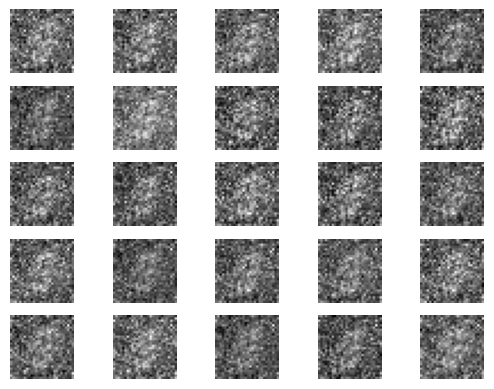

[1/400][0/16] 	Loss_D: 0.9916	Loss_G: -0.7618	D(x): 0.8690	D(G(z)): 0.5727
[2/400][0/16] 	Loss_D: 1.1458	Loss_G: -0.7543	D(x): 0.7681	D(G(z)): 0.5850
[3/400][0/16] 	Loss_D: 1.0639	Loss_G: -0.5363	D(x): 0.7550	D(G(z)): 0.5415
[4/400][0/16] 	Loss_D: 1.1333	Loss_G: -0.5278	D(x): 0.7073	D(G(z)): 0.5427
[5/400][0/16] 	Loss_D: 2.0173	Loss_G: -0.9992	D(x): 0.5652	D(G(z)): 0.7559
[6/400][0/16] 	Loss_D: 0.3566	Loss_G: -0.1495	D(x): 0.9006	D(G(z)): 0.2167
[7/400][0/16] 	Loss_D: 1.3502	Loss_G: -0.5695	D(x): 0.5741	D(G(z)): 0.5470
[8/400][0/16] 	Loss_D: 0.2606	Loss_G: -0.1198	D(x): 0.9111	D(G(z)): 0.1468
[9/400][0/16] 	Loss_D: 1.0249	Loss_G: -0.5071	D(x): 0.6833	D(G(z)): 0.4663
[10/400][0/16] 	Loss_D: 1.0636	Loss_G: -0.5121	D(x): 0.6303	D(G(z)): 0.4457
[11/400][0/16] 	Loss_D: 1.1691	Loss_G: -0.5397	D(x): 0.6032	D(G(z)): 0.4811
[12/400][0/16] 	Loss_D: 1.0781	Loss_G: -0.5462	D(x): 0.6553	D(G(z)): 0.4748
[13/400][0/16] 	Loss_D: 0.6610	Loss_G: -0.2784	D(x): 0.7482	D(G(z)): 0.3041
[14/400][0/16] 	Loss_

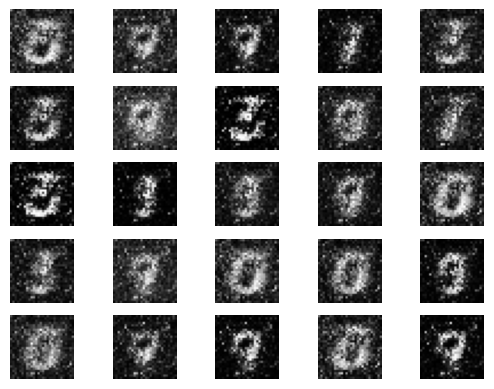

[26/400][0/16] 	Loss_D: 0.6784	Loss_G: -0.1428	D(x): 0.8408	D(G(z)): 0.3800
[27/400][0/16] 	Loss_D: 1.5866	Loss_G: -0.1135	D(x): 0.9483	D(G(z)): 0.7691
[28/400][0/16] 	Loss_D: 0.6008	Loss_G: -0.2418	D(x): 0.7823	D(G(z)): 0.2534
[29/400][0/16] 	Loss_D: 1.4740	Loss_G: -0.4640	D(x): 0.8362	D(G(z)): 0.6755
[30/400][0/16] 	Loss_D: 0.5394	Loss_G: -0.2500	D(x): 0.7945	D(G(z)): 0.2359
[31/400][0/16] 	Loss_D: 1.3112	Loss_G: -0.4987	D(x): 0.5789	D(G(z)): 0.4697
[32/400][0/16] 	Loss_D: 0.8580	Loss_G: -0.2572	D(x): 0.7618	D(G(z)): 0.4065
[33/400][0/16] 	Loss_D: 0.7445	Loss_G: -0.2928	D(x): 0.6483	D(G(z)): 0.2416
[34/400][0/16] 	Loss_D: 0.8818	Loss_G: -0.5738	D(x): 0.5188	D(G(z)): 0.1322
[35/400][0/16] 	Loss_D: 1.0777	Loss_G: -0.4648	D(x): 0.4591	D(G(z)): 0.1624
[36/400][0/16] 	Loss_D: 0.8161	Loss_G: -0.1547	D(x): 0.8659	D(G(z)): 0.4736
[37/400][0/16] 	Loss_D: 0.6652	Loss_G: -0.2420	D(x): 0.7502	D(G(z)): 0.2796
[38/400][0/16] 	Loss_D: 0.7923	Loss_G: -0.3046	D(x): 0.6433	D(G(z)): 0.2400
[39/400][0/1

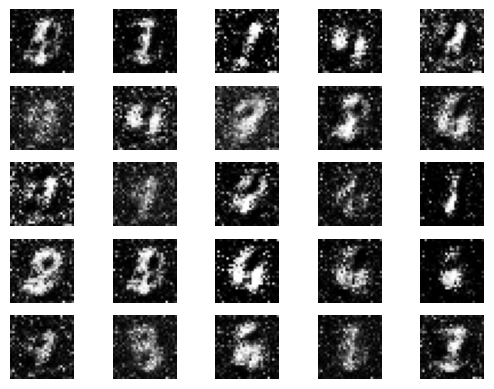

[51/400][0/16] 	Loss_D: 0.4601	Loss_G: -0.1382	D(x): 0.8625	D(G(z)): 0.2438
[52/400][0/16] 	Loss_D: 0.6060	Loss_G: -0.3771	D(x): 0.6944	D(G(z)): 0.1600
[53/400][0/16] 	Loss_D: 0.5507	Loss_G: -0.3043	D(x): 0.7337	D(G(z)): 0.1592
[54/400][0/16] 	Loss_D: 1.4709	Loss_G: -0.0593	D(x): 0.9659	D(G(z)): 0.7217
[55/400][0/16] 	Loss_D: 0.7919	Loss_G: -0.3817	D(x): 0.6236	D(G(z)): 0.1844
[56/400][0/16] 	Loss_D: 0.4993	Loss_G: -0.1505	D(x): 0.7951	D(G(z)): 0.2018
[57/400][0/16] 	Loss_D: 1.0440	Loss_G: -1.3029	D(x): 0.4745	D(G(z)): 0.0422
[58/400][0/16] 	Loss_D: 0.5100	Loss_G: -0.1635	D(x): 0.8089	D(G(z)): 0.2360
[59/400][0/16] 	Loss_D: 0.4645	Loss_G: -0.3523	D(x): 0.7204	D(G(z)): 0.0744
[60/400][0/16] 	Loss_D: 0.5526	Loss_G: -0.2122	D(x): 0.7282	D(G(z)): 0.1331
[61/400][0/16] 	Loss_D: 0.4143	Loss_G: -0.1195	D(x): 0.8696	D(G(z)): 0.2161
[62/400][0/16] 	Loss_D: 0.8127	Loss_G: -0.3460	D(x): 0.6192	D(G(z)): 0.0970
[63/400][0/16] 	Loss_D: 1.0128	Loss_G: -0.0182	D(x): 0.9250	D(G(z)): 0.5735
[64/400][0/1

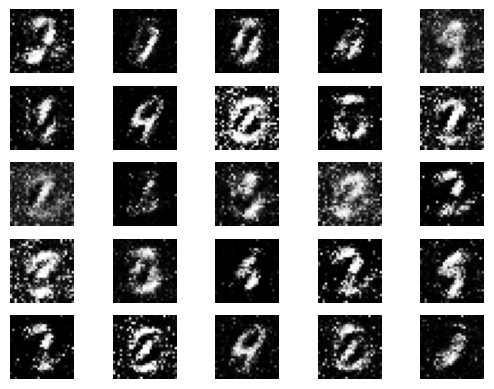

[76/400][0/16] 	Loss_D: 0.9891	Loss_G: -0.0052	D(x): 0.9587	D(G(z)): 0.5597
[77/400][0/16] 	Loss_D: 0.8902	Loss_G: -0.3190	D(x): 0.5694	D(G(z)): 0.0803
[78/400][0/16] 	Loss_D: 0.4946	Loss_G: -0.1104	D(x): 0.8737	D(G(z)): 0.2749
[79/400][0/16] 	Loss_D: 0.5998	Loss_G: -0.2680	D(x): 0.8350	D(G(z)): 0.3011
[80/400][0/16] 	Loss_D: 0.4783	Loss_G: -0.0744	D(x): 0.8996	D(G(z)): 0.2921
[81/400][0/16] 	Loss_D: 1.3549	Loss_G: -0.2299	D(x): 0.9526	D(G(z)): 0.6377
[82/400][0/16] 	Loss_D: 0.5560	Loss_G: -0.2608	D(x): 0.7004	D(G(z)): 0.0855
[83/400][0/16] 	Loss_D: 0.4620	Loss_G: -0.1007	D(x): 0.8368	D(G(z)): 0.1998
[84/400][0/16] 	Loss_D: 0.6277	Loss_G: -0.1702	D(x): 0.7551	D(G(z)): 0.2249
[85/400][0/16] 	Loss_D: 0.5485	Loss_G: -0.2367	D(x): 0.7818	D(G(z)): 0.1871
[86/400][0/16] 	Loss_D: 0.7049	Loss_G: -0.0218	D(x): 0.9192	D(G(z)): 0.4168
[87/400][0/16] 	Loss_D: 1.1649	Loss_G: -0.4219	D(x): 0.4636	D(G(z)): 0.0421
[88/400][0/16] 	Loss_D: 0.5477	Loss_G: -0.0568	D(x): 0.8871	D(G(z)): 0.3185
[89/400][0/1

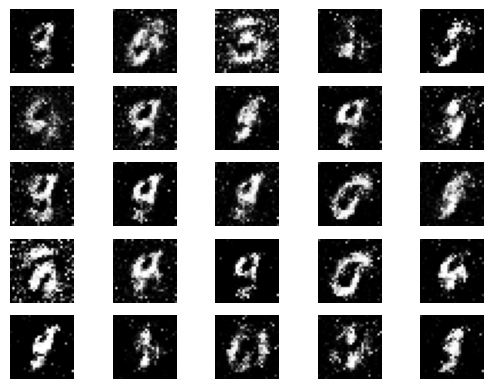

[101/400][0/16] 	Loss_D: 0.5392	Loss_G: -0.2946	D(x): 0.7606	D(G(z)): 0.1726
[102/400][0/16] 	Loss_D: 0.7593	Loss_G: -0.6381	D(x): 0.6209	D(G(z)): 0.0951
[103/400][0/16] 	Loss_D: 0.4994	Loss_G: -0.2732	D(x): 0.7636	D(G(z)): 0.1307
[104/400][0/16] 	Loss_D: 0.6691	Loss_G: -0.2779	D(x): 0.6592	D(G(z)): 0.1292
[105/400][0/16] 	Loss_D: 1.2750	Loss_G: -0.0627	D(x): 0.8875	D(G(z)): 0.6283
[106/400][0/16] 	Loss_D: 0.6067	Loss_G: -0.0528	D(x): 0.9161	D(G(z)): 0.3724
[107/400][0/16] 	Loss_D: 0.4310	Loss_G: -0.2094	D(x): 0.7899	D(G(z)): 0.1270
[108/400][0/16] 	Loss_D: 1.4158	Loss_G: -0.8438	D(x): 0.3721	D(G(z)): 0.0697
[109/400][0/16] 	Loss_D: 0.5232	Loss_G: -0.1426	D(x): 0.8099	D(G(z)): 0.2270
[110/400][0/16] 	Loss_D: 0.5966	Loss_G: -0.2532	D(x): 0.6838	D(G(z)): 0.0966
[111/400][0/16] 	Loss_D: 0.6734	Loss_G: -0.3298	D(x): 0.7002	D(G(z)): 0.1750
[112/400][0/16] 	Loss_D: 0.6491	Loss_G: -0.0538	D(x): 0.8774	D(G(z)): 0.3603
[113/400][0/16] 	Loss_D: 0.4875	Loss_G: -0.1963	D(x): 0.7997	D(G(z)): 0.1889

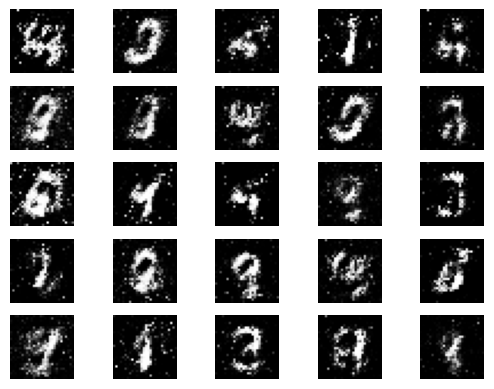

[126/400][0/16] 	Loss_D: 0.4956	Loss_G: -0.2988	D(x): 0.8216	D(G(z)): 0.1834
[127/400][0/16] 	Loss_D: 0.4393	Loss_G: -0.1978	D(x): 0.7880	D(G(z)): 0.1220
[128/400][0/16] 	Loss_D: 0.4560	Loss_G: -0.0112	D(x): 0.9590	D(G(z)): 0.3105
[129/400][0/16] 	Loss_D: 0.3318	Loss_G: -0.0384	D(x): 0.9200	D(G(z)): 0.1941
[130/400][0/16] 	Loss_D: 0.5542	Loss_G: -0.2282	D(x): 0.7034	D(G(z)): 0.0789
[131/400][0/16] 	Loss_D: 0.4311	Loss_G: -0.2269	D(x): 0.8042	D(G(z)): 0.1368
[132/400][0/16] 	Loss_D: 0.3075	Loss_G: -0.1138	D(x): 0.8236	D(G(z)): 0.0729
[133/400][0/16] 	Loss_D: 0.6970	Loss_G: -0.0195	D(x): 0.9427	D(G(z)): 0.3964
[134/400][0/16] 	Loss_D: 1.9712	Loss_G: -0.6927	D(x): 0.3132	D(G(z)): 0.0052
[135/400][0/16] 	Loss_D: 1.3648	Loss_G: -0.2493	D(x): 0.4543	D(G(z)): 0.0275
[136/400][0/16] 	Loss_D: 0.6320	Loss_G: -0.0815	D(x): 0.8949	D(G(z)): 0.3326
[137/400][0/16] 	Loss_D: 0.4525	Loss_G: -0.1999	D(x): 0.8135	D(G(z)): 0.1753
[138/400][0/16] 	Loss_D: 0.7624	Loss_G: -0.0554	D(x): 0.9189	D(G(z)): 0.4079

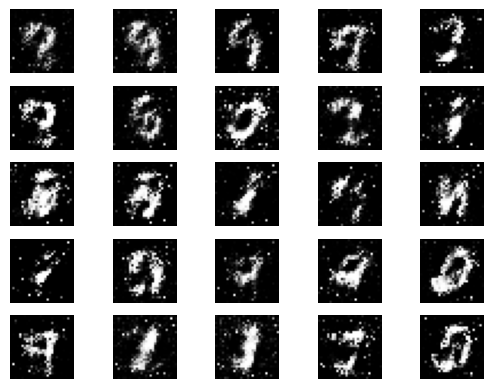

[151/400][0/16] 	Loss_D: 0.5985	Loss_G: -0.0917	D(x): 0.9227	D(G(z)): 0.3601
[152/400][0/16] 	Loss_D: 0.4138	Loss_G: -0.2379	D(x): 0.7670	D(G(z)): 0.0715
[153/400][0/16] 	Loss_D: 0.9169	Loss_G: -0.4558	D(x): 0.5308	D(G(z)): 0.0356
[154/400][0/16] 	Loss_D: 0.4865	Loss_G: -0.1650	D(x): 0.8109	D(G(z)): 0.2072
[155/400][0/16] 	Loss_D: 0.7131	Loss_G: -0.0307	D(x): 0.9253	D(G(z)): 0.4090
[156/400][0/16] 	Loss_D: 0.3799	Loss_G: -0.1309	D(x): 0.7961	D(G(z)): 0.0839
[157/400][0/16] 	Loss_D: 0.3689	Loss_G: -0.1839	D(x): 0.7960	D(G(z)): 0.0719
[158/400][0/16] 	Loss_D: 0.8749	Loss_G: -0.0551	D(x): 0.9052	D(G(z)): 0.4833
[159/400][0/16] 	Loss_D: 0.4015	Loss_G: -0.2188	D(x): 0.8013	D(G(z)): 0.1315
[160/400][0/16] 	Loss_D: 0.8190	Loss_G: -0.0132	D(x): 0.9415	D(G(z)): 0.4659
[161/400][0/16] 	Loss_D: 1.0933	Loss_G: -0.3217	D(x): 0.4808	D(G(z)): 0.0234
[162/400][0/16] 	Loss_D: 0.9264	Loss_G: -0.0211	D(x): 0.9482	D(G(z)): 0.5294
[163/400][0/16] 	Loss_D: 0.3447	Loss_G: -0.1265	D(x): 0.8505	D(G(z)): 0.1253

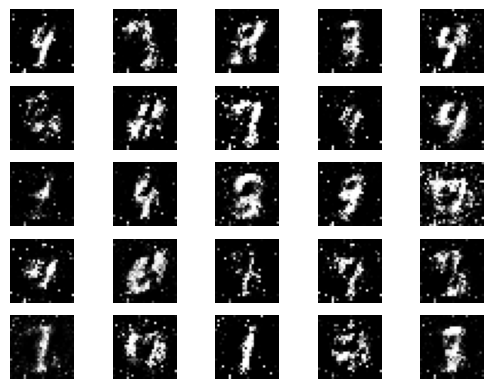

[176/400][0/16] 	Loss_D: 0.5462	Loss_G: -0.3529	D(x): 0.6898	D(G(z)): 0.0486
[177/400][0/16] 	Loss_D: 1.1218	Loss_G: -0.2488	D(x): 0.4970	D(G(z)): 0.0385
[178/400][0/16] 	Loss_D: 0.5039	Loss_G: -0.1067	D(x): 0.8533	D(G(z)): 0.2537
[179/400][0/16] 	Loss_D: 0.4082	Loss_G: -0.2083	D(x): 0.7915	D(G(z)): 0.1024
[180/400][0/16] 	Loss_D: 0.5431	Loss_G: -0.6721	D(x): 0.7516	D(G(z)): 0.1027
[181/400][0/16] 	Loss_D: 0.5854	Loss_G: -0.2667	D(x): 0.6932	D(G(z)): 0.0613
[182/400][0/16] 	Loss_D: 0.4571	Loss_G: -0.1603	D(x): 0.7723	D(G(z)): 0.1001
[183/400][0/16] 	Loss_D: 0.5444	Loss_G: -0.2606	D(x): 0.6831	D(G(z)): 0.0485
[184/400][0/16] 	Loss_D: 0.3724	Loss_G: -0.1109	D(x): 0.8569	D(G(z)): 0.1537
[185/400][0/16] 	Loss_D: 0.5800	Loss_G: -0.4050	D(x): 0.7035	D(G(z)): 0.0692
[186/400][0/16] 	Loss_D: 0.4720	Loss_G: -0.2816	D(x): 0.7891	D(G(z)): 0.1574
[187/400][0/16] 	Loss_D: 0.2733	Loss_G: -0.0636	D(x): 0.8983	D(G(z)): 0.1357
[188/400][0/16] 	Loss_D: 0.4728	Loss_G: -0.1976	D(x): 0.7393	D(G(z)): 0.0643

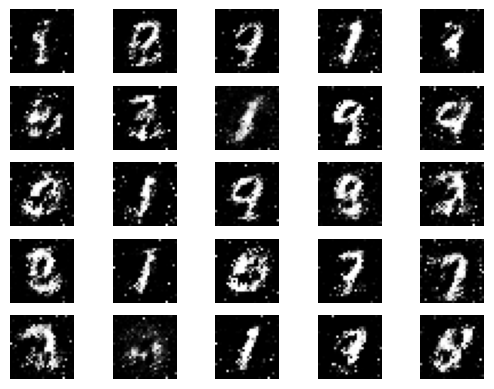

[201/400][0/16] 	Loss_D: 0.2373	Loss_G: -0.0621	D(x): 0.9143	D(G(z)): 0.1161
[202/400][0/16] 	Loss_D: 0.1926	Loss_G: -0.0681	D(x): 0.9219	D(G(z)): 0.0906
[203/400][0/16] 	Loss_D: 0.1708	Loss_G: -0.0375	D(x): 0.9456	D(G(z)): 0.0993
[204/400][0/16] 	Loss_D: 0.3021	Loss_G: -0.0464	D(x): 0.9286	D(G(z)): 0.1714
[205/400][0/16] 	Loss_D: 0.3229	Loss_G: -0.0452	D(x): 0.9334	D(G(z)): 0.1908
[206/400][0/16] 	Loss_D: 0.2258	Loss_G: -0.1101	D(x): 0.8971	D(G(z)): 0.0802
[207/400][0/16] 	Loss_D: 0.3362	Loss_G: -0.2707	D(x): 0.8063	D(G(z)): 0.0216
[208/400][0/16] 	Loss_D: 0.2365	Loss_G: -0.1288	D(x): 0.8596	D(G(z)): 0.0389
[209/400][0/16] 	Loss_D: 1.4168	Loss_G: -0.3624	D(x): 0.4672	D(G(z)): 0.0045
[210/400][0/16] 	Loss_D: 0.2571	Loss_G: -0.0905	D(x): 0.8826	D(G(z)): 0.0908
[211/400][0/16] 	Loss_D: 0.2072	Loss_G: -0.0561	D(x): 0.9214	D(G(z)): 0.0777
[212/400][0/16] 	Loss_D: 1.3823	Loss_G: -0.1375	D(x): 0.5335	D(G(z)): 0.0135
[213/400][0/16] 	Loss_D: 0.5884	Loss_G: -0.0877	D(x): 0.9363	D(G(z)): 0.3295

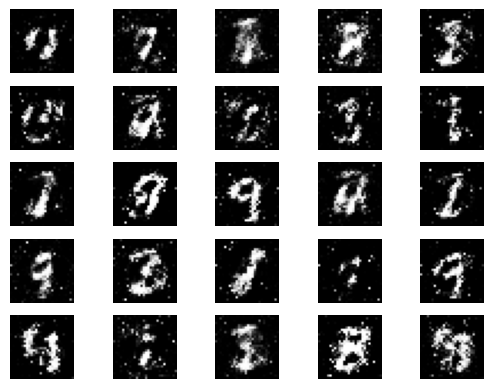

[226/400][0/16] 	Loss_D: 0.3121	Loss_G: -0.0855	D(x): 0.8351	D(G(z)): 0.0929
[227/400][0/16] 	Loss_D: 0.7527	Loss_G: -0.0121	D(x): 0.9490	D(G(z)): 0.4310
[228/400][0/16] 	Loss_D: 0.4966	Loss_G: -0.0775	D(x): 0.8688	D(G(z)): 0.2315
[229/400][0/16] 	Loss_D: 0.3148	Loss_G: -0.1415	D(x): 0.8725	D(G(z)): 0.1198
[230/400][0/16] 	Loss_D: 0.3705	Loss_G: -0.2432	D(x): 0.7897	D(G(z)): 0.0633
[231/400][0/16] 	Loss_D: 0.5185	Loss_G: -0.2337	D(x): 0.7444	D(G(z)): 0.0908
[232/400][0/16] 	Loss_D: 0.9604	Loss_G: -0.0160	D(x): 0.9624	D(G(z)): 0.5463
[233/400][0/16] 	Loss_D: 0.5854	Loss_G: -0.4264	D(x): 0.6775	D(G(z)): 0.0305
[234/400][0/16] 	Loss_D: 0.4784	Loss_G: -0.0841	D(x): 0.8590	D(G(z)): 0.2147
[235/400][0/16] 	Loss_D: 0.6375	Loss_G: -0.2910	D(x): 0.6940	D(G(z)): 0.0263
[236/400][0/16] 	Loss_D: 0.4288	Loss_G: -0.1785	D(x): 0.8438	D(G(z)): 0.1437
[237/400][0/16] 	Loss_D: 0.5520	Loss_G: -0.0825	D(x): 0.9052	D(G(z)): 0.3037
[238/400][0/16] 	Loss_D: 0.3691	Loss_G: -0.0921	D(x): 0.8741	D(G(z)): 0.1669

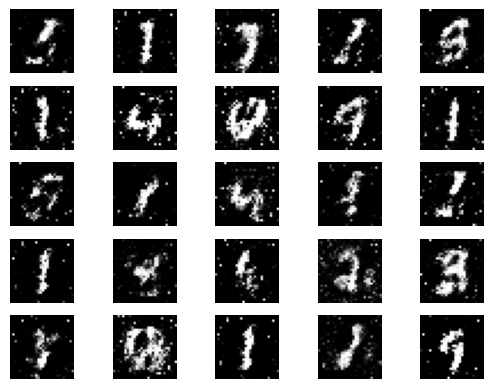

[251/400][0/16] 	Loss_D: 0.4158	Loss_G: -0.1599	D(x): 0.8490	D(G(z)): 0.1659
[252/400][0/16] 	Loss_D: 0.6695	Loss_G: -0.3629	D(x): 0.6736	D(G(z)): 0.0598
[253/400][0/16] 	Loss_D: 0.3748	Loss_G: -0.1194	D(x): 0.8874	D(G(z)): 0.1898
[254/400][0/16] 	Loss_D: 0.6346	Loss_G: -0.0581	D(x): 0.9078	D(G(z)): 0.3506
[255/400][0/16] 	Loss_D: 0.4084	Loss_G: -0.2402	D(x): 0.8006	D(G(z)): 0.1043
[256/400][0/16] 	Loss_D: 1.2559	Loss_G: -0.5172	D(x): 0.4722	D(G(z)): 0.0072
[257/400][0/16] 	Loss_D: 0.6637	Loss_G: -0.2804	D(x): 0.6673	D(G(z)): 0.0599
[258/400][0/16] 	Loss_D: 0.3075	Loss_G: -0.0919	D(x): 0.8586	D(G(z)): 0.1048
[259/400][0/16] 	Loss_D: 0.3719	Loss_G: -0.1630	D(x): 0.8253	D(G(z)): 0.1135
[260/400][0/16] 	Loss_D: 0.4756	Loss_G: -0.0655	D(x): 0.8950	D(G(z)): 0.2611
[261/400][0/16] 	Loss_D: 0.4430	Loss_G: -0.0542	D(x): 0.9166	D(G(z)): 0.2505
[262/400][0/16] 	Loss_D: 0.3737	Loss_G: -0.0977	D(x): 0.8934	D(G(z)): 0.1743
[263/400][0/16] 	Loss_D: 0.8859	Loss_G: -0.0092	D(x): 0.9357	D(G(z)): 0.4937

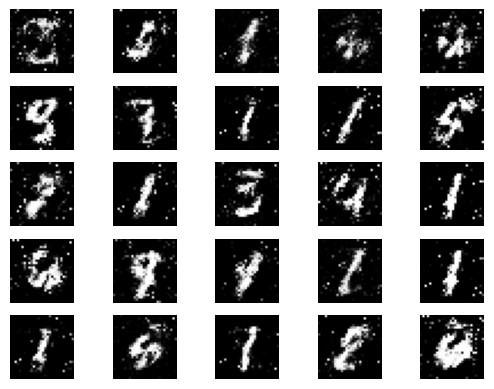

[276/400][0/16] 	Loss_D: 0.5784	Loss_G: -0.6134	D(x): 0.6900	D(G(z)): 0.0959
[277/400][0/16] 	Loss_D: 0.4139	Loss_G: -0.1553	D(x): 0.8479	D(G(z)): 0.1803
[278/400][0/16] 	Loss_D: 0.5517	Loss_G: -0.1754	D(x): 0.7240	D(G(z)): 0.1017
[279/400][0/16] 	Loss_D: 0.4940	Loss_G: -0.1696	D(x): 0.8499	D(G(z)): 0.2387
[280/400][0/16] 	Loss_D: 0.5749	Loss_G: -0.1567	D(x): 0.8674	D(G(z)): 0.2849
[281/400][0/16] 	Loss_D: 0.3209	Loss_G: -0.0785	D(x): 0.8767	D(G(z)): 0.1471
[282/400][0/16] 	Loss_D: 0.4325	Loss_G: -0.3511	D(x): 0.8156	D(G(z)): 0.1173
[283/400][0/16] 	Loss_D: 0.6964	Loss_G: -0.6588	D(x): 0.6536	D(G(z)): 0.0816
[284/400][0/16] 	Loss_D: 0.3626	Loss_G: -0.0790	D(x): 0.8836	D(G(z)): 0.1742
[285/400][0/16] 	Loss_D: 0.3224	Loss_G: -0.1490	D(x): 0.8295	D(G(z)): 0.0620
[286/400][0/16] 	Loss_D: 1.5729	Loss_G: -0.0012	D(x): 0.9913	D(G(z)): 0.7116
[287/400][0/16] 	Loss_D: 0.4357	Loss_G: -0.1675	D(x): 0.8145	D(G(z)): 0.1303
[288/400][0/16] 	Loss_D: 0.3290	Loss_G: -0.1003	D(x): 0.8835	D(G(z)): 0.1538

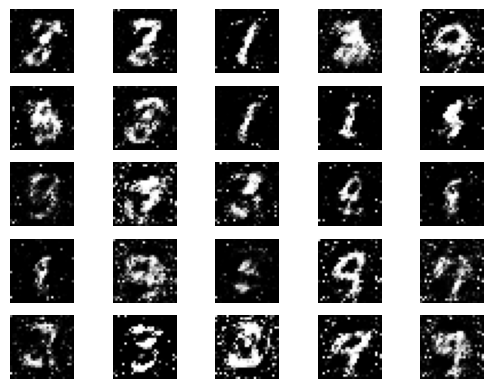

[301/400][0/16] 	Loss_D: 0.5807	Loss_G: -0.3434	D(x): 0.6654	D(G(z)): 0.0584
[302/400][0/16] 	Loss_D: 0.9509	Loss_G: -0.0104	D(x): 0.9501	D(G(z)): 0.5272
[303/400][0/16] 	Loss_D: 0.4085	Loss_G: -0.1979	D(x): 0.8461	D(G(z)): 0.1488
[304/400][0/16] 	Loss_D: 0.4893	Loss_G: -0.2076	D(x): 0.8191	D(G(z)): 0.1909
[305/400][0/16] 	Loss_D: 0.4350	Loss_G: -0.2480	D(x): 0.7791	D(G(z)): 0.1092
[306/400][0/16] 	Loss_D: 0.5674	Loss_G: -0.0935	D(x): 0.9147	D(G(z)): 0.3091
[307/400][0/16] 	Loss_D: 0.3684	Loss_G: -0.0674	D(x): 0.8261	D(G(z)): 0.0680
[308/400][0/16] 	Loss_D: 0.4177	Loss_G: -0.0888	D(x): 0.9125	D(G(z)): 0.2432
[309/400][0/16] 	Loss_D: 0.9471	Loss_G: -0.0345	D(x): 0.9626	D(G(z)): 0.4894
[310/400][0/16] 	Loss_D: 0.9065	Loss_G: -0.0498	D(x): 0.8953	D(G(z)): 0.4436
[311/400][0/16] 	Loss_D: 0.5532	Loss_G: -0.2711	D(x): 0.7181	D(G(z)): 0.0919
[312/400][0/16] 	Loss_D: 0.3549	Loss_G: -0.0942	D(x): 0.7904	D(G(z)): 0.0471
[313/400][0/16] 	Loss_D: 0.5118	Loss_G: -0.0731	D(x): 0.8942	D(G(z)): 0.2807

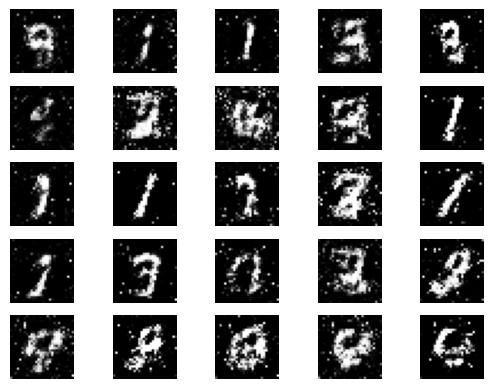

[326/400][0/16] 	Loss_D: 0.5427	Loss_G: -0.0824	D(x): 0.8955	D(G(z)): 0.3048
[327/400][0/16] 	Loss_D: 0.4113	Loss_G: -0.1752	D(x): 0.8246	D(G(z)): 0.1557
[328/400][0/16] 	Loss_D: 0.3749	Loss_G: -0.1999	D(x): 0.8217	D(G(z)): 0.1269
[329/400][0/16] 	Loss_D: 0.5930	Loss_G: -0.2029	D(x): 0.7588	D(G(z)): 0.1857
[330/400][0/16] 	Loss_D: 0.4067	Loss_G: -0.1564	D(x): 0.8105	D(G(z)): 0.1288
[331/400][0/16] 	Loss_D: 1.4820	Loss_G: -0.0331	D(x): 0.9522	D(G(z)): 0.6868
[332/400][0/16] 	Loss_D: 0.5418	Loss_G: -0.2826	D(x): 0.7607	D(G(z)): 0.1648
[333/400][0/16] 	Loss_D: 0.9853	Loss_G: -0.0457	D(x): 0.9453	D(G(z)): 0.5380
[334/400][0/16] 	Loss_D: 1.2035	Loss_G: -0.0187	D(x): 0.9556	D(G(z)): 0.5871
[335/400][0/16] 	Loss_D: 0.6325	Loss_G: -0.3886	D(x): 0.6673	D(G(z)): 0.0889
[336/400][0/16] 	Loss_D: 0.7385	Loss_G: -0.1100	D(x): 0.8830	D(G(z)): 0.3917
[337/400][0/16] 	Loss_D: 0.5838	Loss_G: -0.3090	D(x): 0.7070	D(G(z)): 0.1308
[338/400][0/16] 	Loss_D: 1.3780	Loss_G: -0.0196	D(x): 0.9577	D(G(z)): 0.6795

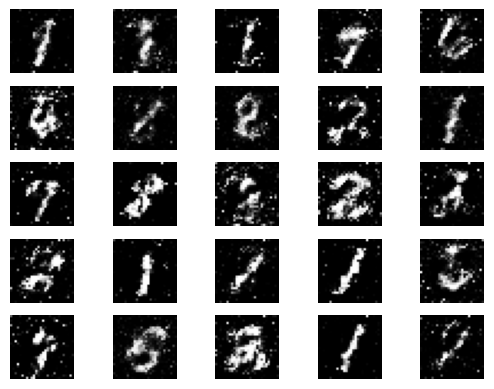

[351/400][0/16] 	Loss_D: 0.6269	Loss_G: -0.1426	D(x): 0.8706	D(G(z)): 0.3209
[352/400][0/16] 	Loss_D: 1.8514	Loss_G: -0.0086	D(x): 0.9704	D(G(z)): 0.7837
[353/400][0/16] 	Loss_D: 0.9724	Loss_G: -0.0866	D(x): 0.9025	D(G(z)): 0.4767
[354/400][0/16] 	Loss_D: 1.2210	Loss_G: -0.0501	D(x): 0.9605	D(G(z)): 0.6157
[355/400][0/16] 	Loss_D: 1.3591	Loss_G: -1.1132	D(x): 0.3904	D(G(z)): 0.0417
[356/400][0/16] 	Loss_D: 0.6601	Loss_G: -0.4232	D(x): 0.6771	D(G(z)): 0.1538
[357/400][0/16] 	Loss_D: 0.7782	Loss_G: -0.4356	D(x): 0.6690	D(G(z)): 0.2170
[358/400][0/16] 	Loss_D: 0.7752	Loss_G: -0.0888	D(x): 0.8981	D(G(z)): 0.4241
[359/400][0/16] 	Loss_D: 0.6587	Loss_G: -0.0989	D(x): 0.8720	D(G(z)): 0.3202
[360/400][0/16] 	Loss_D: 0.6771	Loss_G: -0.2193	D(x): 0.6756	D(G(z)): 0.1332
[361/400][0/16] 	Loss_D: 0.6099	Loss_G: -0.3391	D(x): 0.7156	D(G(z)): 0.1613
[362/400][0/16] 	Loss_D: 1.3721	Loss_G: -0.0470	D(x): 0.9516	D(G(z)): 0.6757
[363/400][0/16] 	Loss_D: 0.6943	Loss_G: -0.4272	D(x): 0.6394	D(G(z)): 0.0960

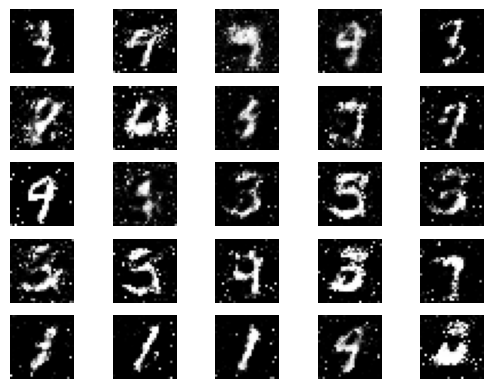

[376/400][0/16] 	Loss_D: 1.0025	Loss_G: -0.6617	D(x): 0.4924	D(G(z)): 0.0775
[377/400][0/16] 	Loss_D: 0.5696	Loss_G: -0.3279	D(x): 0.7032	D(G(z)): 0.1341
[378/400][0/16] 	Loss_D: 0.6400	Loss_G: -0.1026	D(x): 0.8790	D(G(z)): 0.3467
[379/400][0/16] 	Loss_D: 1.0228	Loss_G: -0.0954	D(x): 0.9184	D(G(z)): 0.5511
[380/400][0/16] 	Loss_D: 1.0705	Loss_G: -0.7733	D(x): 0.4669	D(G(z)): 0.0615
[381/400][0/16] 	Loss_D: 0.6236	Loss_G: -0.1186	D(x): 0.8428	D(G(z)): 0.3167
[382/400][0/16] 	Loss_D: 0.6005	Loss_G: -0.1340	D(x): 0.8257	D(G(z)): 0.2941
[383/400][0/16] 	Loss_D: 0.7285	Loss_G: -0.5218	D(x): 0.5769	D(G(z)): 0.0512
[384/400][0/16] 	Loss_D: 0.7548	Loss_G: -0.6184	D(x): 0.6034	D(G(z)): 0.0913
[385/400][0/16] 	Loss_D: 0.7745	Loss_G: -0.1351	D(x): 0.8539	D(G(z)): 0.3995
[386/400][0/16] 	Loss_D: 0.5335	Loss_G: -0.1654	D(x): 0.8077	D(G(z)): 0.2217
[387/400][0/16] 	Loss_D: 1.9030	Loss_G: -0.0092	D(x): 0.9837	D(G(z)): 0.7898
[388/400][0/16] 	Loss_D: 0.7432	Loss_G: -0.1801	D(x): 0.8068	D(G(z)): 0.3294

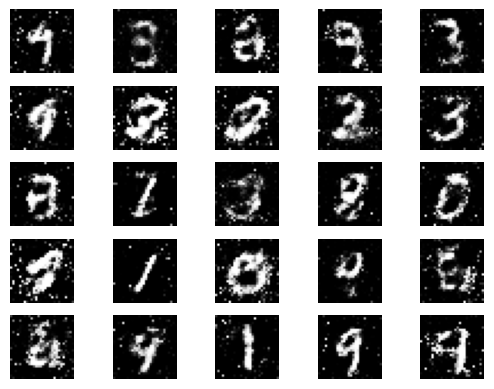

In [ ]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0, n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0].to(device)
      true_labels = torch.ones(len(true_imgs), dtype=torch.float, device=device) # FILL IN HERE. CAREFUL, WE WANT A 1-DIMENSIONAL TENSOR OF LABELS (DUE TO THE "VIEW" IN NEXT LINE)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs).view(-1) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(batch_size, z_dim, device=device) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)  # FILL IN HERE
      fake_labels = torch.zeros(len(z_latent_noise), dtype=torch.float, device=device) # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()).view(-1)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)  # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs).view(-1) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())


  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


Hopefully, you have managed to get the GAN working. Yoohoo !! You should notice that the results are much less smooth than those of the variational autoencoder. This is normal, in general a GAN produces sharper results, but is quite difficult to get working well. You can try and modify the latent space to see whether this improves the results.

## Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

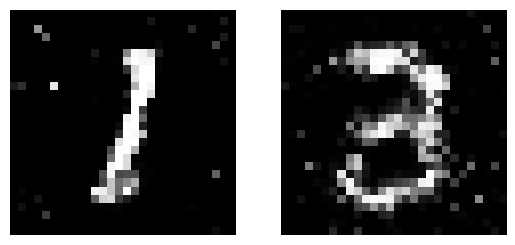

In [55]:
# first image
random_seed = 10 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(1, z_dim, device=device) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 16 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.randn(1, z_dim, device=device) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE

# display images

x_0 = x_0.cpu().detach().numpy()
x_1 = x_1.cpu().detach().numpy()


# Plot the two images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_0[0,0,:,:], cmap='gray')
axs[0].axis('off')

axs[1].imshow(x_1[0,0,:,:], cmap='gray')
axs[1].axis('off')
plt.show()


Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [64]:
n_interpolation = 20

# FILL IN HERE
interpolated_latent = [z_0]

for i in range(1, n_interpolation):
    alpha = i / n_interpolation
    interpolated_latent.append(alpha*z_1 + (1-alpha)*z_0)

interpolated_latent.append(z_1)

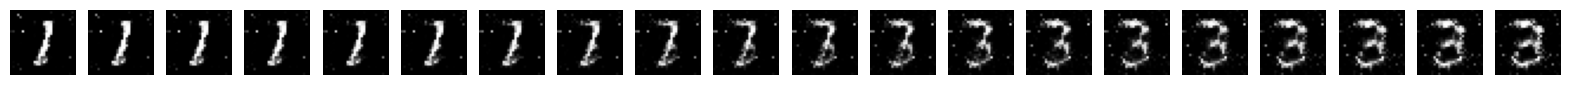

In [65]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  interpolated_image = gen_model(interpolated_latent[i]).cpu().detach().numpy()
  axs[i].imshow(interpolated_image[0, 0, :, :], cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

### Evaluation

Now, we are going to evaluate this navigation. We will investigate the following property:

- We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;

For this, we will first need a classification network. Use the following architecture :

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

We also define a function ```get_accuracy``` to calculate the accuracy of our network.

In [90]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy' (already done)

# BEGIN FILL IN HERE
class Classifier(nn.Module):
  def __init__(self):
    print(n_pixels)
    super(Classifier, self).__init__()
    self.conv1 = nn.Conv2d(kernel_size=3,padding="same", in_channels=1, out_channels=32)
    self.conv2 = nn.Conv2d(kernel_size=3, padding="same", in_channels=32, out_channels=32)
    self.mp = nn.MaxPool2d(stride=2, kernel_size=2)
    self.fc = nn.Linear(32*14*14, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # shape: 32x28x28
    x = F.relu(self.conv2(x)) # shape: 32x28x28
    x = self.mp(x)  # shape: 32x14x14
    x = x.view(-1, 32*14*14)
    x = self.fc(x)  # shape: 10
    return x

# END FILL IN HERE

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [91]:
# train the classifier

classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(classifier.parameters(), lr=0.001)

n_epochs = 10

for epoch in range(n_epochs):
    for i, data in enumerate(mnist_train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        if i % 200 == 0:
            print('[%d/%d][%d/%d] \tLoss: %.4f' % (epoch, n_epochs, i, len(mnist_train_loader), loss.item()))

784
[0/10][0/16] 	Loss: 2.3075
[1/10][0/16] 	Loss: 0.9232
[2/10][0/16] 	Loss: 0.3394
[3/10][0/16] 	Loss: 0.2281
[4/10][0/16] 	Loss: 0.1913
[5/10][0/16] 	Loss: 0.0887
[6/10][0/16] 	Loss: 0.1893
[7/10][0/16] 	Loss: 0.0314
[8/10][0/16] 	Loss: 0.0534
[9/10][0/16] 	Loss: 0.0356



Now, create a function which returns the classification returned by this network on mnist images. Remember, here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).

In [94]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = classification_model(imgs_in)
  _, output_classes = torch.max(output_classes, 1)
  return(output_classes.item())

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [95]:
z_classes = []

for i in range(n_interpolation+1):
    img = gen_model(interpolated_latent[i])
    img = img.view(-1, 1, n_rows, n_cols)
    img = img.to(device)
    img = img.float()
    img_classes = predict_mnist_class(img, classifier)
    z_classes.append(img_classes)

print(z_classes)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


__Answer__

# Training on CIFAR (optional)

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [96]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

100.0%


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [97]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

Now, carry out the training (use code above)